In [89]:
import cv2
import os
import glob
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import json
import mahotas
from mahotas.thresholding import soft_threshold


In [227]:
ena_local = 'C:/temp/ena/images/test/'
save_loc = 'C:/temp/ena/images/gray_test_wavelet/'
save_loc_labels = 'C:/temp/ena/labels/gray_train100_wavelet/'


In [229]:

images = [os.path.split(i)[1] for i in glob.glob(ena_local + '/*.jpg', recursive=True)]


In [ ]:

metadata_path = 'C:\Projects\wild\data\ENA24\ena24_public.json'
with open(metadata_path) as f:
    d = json.load(f)

In [76]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

In [221]:
bboxbyid = {l['image_id']: (l['bbox'], l['category_id']) for l in d['annotations'] if l['image_id'] in [i.split('.jpg')[0] for i in images]}

In [225]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def saveBbox(im, bbox, cat_id, width, height):
    dw = 1. / width
    dh = 1. / height
    with open(save_loc_labels + im.split('.jpg')[0] + '.txt', "a") as myfile:
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2] + bbox[0]
            ymax = bbox[3] + bbox[1]
            
            x = (xmin + xmax)/2
            y = (ymin + ymax)/2
            
            w = xmax - xmin
            h = ymax-ymin
            
            x = x * dw
            w = w * dw
            y = y * dh
            h = h * dh
            mystring = str(str(cat_id) + " " + str(truncate(x, 7)) + " " + str(truncate(y, 7)) + " " + str(truncate(w, 7)) + " " + str(truncate(h, 7)))
            myfile.write(mystring)
            myfile.write("\n")


In [230]:
width, height = 640, 640
for im in images:
    img = cv2.imread(ena_local + im)
    f = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    reshaped, ratio, pad = letterbox(f, (width, height), auto=False)
    # bbox, cat_id = bboxbyid.get(im.split('.jpg')[0])
    # bbox = np.array(bbox) * ratio[0]
    # bbox[1] = bbox[1] + pad[1]
    # saveBbox(im, bbox, cat_id, width, height)
    t = mahotas.daubechies(reshaped,'D4')
    t /= 8
    t = t.astype(np.int8)
    r = mahotas.idaubechies(t, 'D4')
    cv2.imwrite(save_loc + im, r, [cv2.IMWRITE_JPEG_QUALITY, 75])

{'id': 'd8e94bd2-1df9-11ea-8572-5cf370671a19',
 'image_id': '1',
 'category_id': 0,
 'bbox': [5.47008, 974.4170399999999, 162.279168, 72.97300800000001]}

In [97]:
len(bboxbyid)

6014

In [85]:
pad

(0.0, 80.0)

In [87]:
im

'998.jpg'

In [100]:
labels = np.array([[17, 0.4558405, 0.8266614, 0.214625, 0.3087029]])

In [103]:
import torch

In [104]:
w, h = 640, 640
#fix label:
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y

def xyxy2xywhn(x, w=640, h=640, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y


In [ ]:
labels[:, 1:] = xywhn2xyxy(labels[:, 1:], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1])
labels[:, 1:] = xyxy2xywhn(labels[:, 1:])

In [112]:
testbbox

[258.73728, 884.95632, 140.35872, 158.82372]

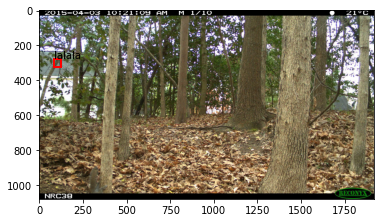

In [120]:
boundingBox(ena_local + '100.jpg', np.array(testbbox) * ratio[0])

In [133]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [212]:
bbox

array([401.25213 , 581.97193 , 186.77304 ,  82.344195])

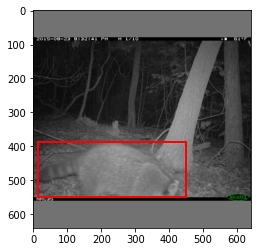

In [217]:
img = Image.open(ena_local + '3858.jpg')
img, ratio, pad = letterbox(np.array(img), (640,640), auto=False)
bbox = testbbox
testbbox = bboxbyid.get('3858')
bbox = np.array(bbox) * ratio[0]
bbox[1] = bbox[1] + pad[1]
fig, ax = plt.subplots()
ax.imshow(img)
rect = matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [115]:
def boundingBox(img: str, bbox: list[3]):
  im = Image.open(img)

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
  plt.text(bbox[0], bbox[1],'lalala')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

In [ ]:
xmin = ann["bbox"][0]
ymin = ann["bbox"][1]
xmax = ann["bbox"][2] + ann["bbox"][0]
ymax = ann["bbox"][3] + ann["bbox"][1]

x = (xmin + xmax)/2
y = (ymin + ymax)/2

w = xmax - xmin
h = ymax-ymin

x = x * dw
w = w * dw
y = y * dh
h = h * dh

In [105]:
labels

array([[ 17.     ,  69.7056 , 214.46199, 112.6306 , 276.20257]])

In [108]:
labels

array([[17.        ,  0.14245016,  0.38333169,  0.06707031,  0.09646966]])

# OLD


Fraction of zeros in original image: 0.04144338348765432


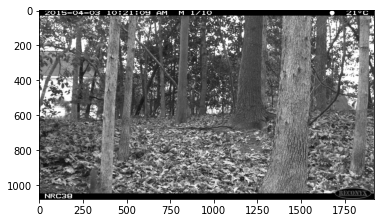

In [26]:
print("Fraction of zeros in original image: {0}".format(np.mean(f==0)))
plt.gray()
plt.imshow(f)
plt.show()

Fraction of zeros in transform (after division by 8): 0.45336516203703703


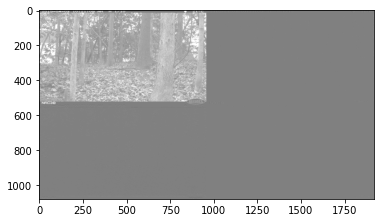

In [40]:
# Transform using D8 Wavelet to obtain transformed image t:
t = mahotas.daubechies(f,'D4')

# Discard low-order bits:
t /= 8
t = t.astype(np.int8)
print("Fraction of zeros in transform (after division by 8): {0}".format(np.mean(t==0)))
plt.imshow(t)
plt.show()

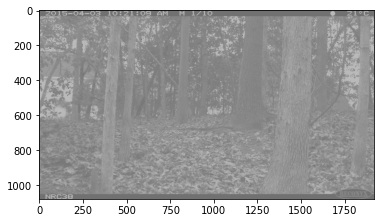

In [41]:
# Let us look at what this looks like
r = mahotas.idaubechies(t, 'D8')
plt.imshow(r)
plt.show()

In [42]:
im = Image.fromarray(r)

In [54]:
cv2.imwrite('c:/temp/compressed.jpg', r, [cv2.IMWRITE_JPEG_QUALITY, 25])
cv2.imwrite('c:/temp/compressed_no_wavelet.jpg', f, [cv2.IMWRITE_JPEG_QUALITY, 25])

True

In [49]:
backtorgb = cv2.cvtColor(r.astype(np.uint8),cv2.COLOR_GRAY2RGB)

In [50]:
cv2.imwrite('c:/temp/test.jpg', backtorgb)

True

In [56]:
reshaped = letterbox(r, (640,640), auto=False)[0]

In [57]:
cv2.imwrite('c:/temp/compressed_reshaped.jpg', reshaped, [cv2.IMWRITE_JPEG_QUALITY, 25])

True

In [82]:
cv2.imwrite('c:/temp/reshaped_compressed_75.jpg', r, [cv2.IMWRITE_JPEG_QUALITY, 75])

True

In [ ]:
reshaped2 = letterbox(f, (640,640), auto=False)[0]

In [ ]:
cv2.imwrite('c:/temp/reshaped_compressed_nowavelet.jpg', reshaped, [cv2.IMWRITE_JPEG_QUALITY, 25])

In [63]:
cv2.imwrite('c:/temp/just_reshaped.jpg', reshaped2, [cv2.IMWRITE_JPEG_QUALITY, 25])

True

In [79]:
cv2.imwrite('c:/temp/just_reshaped_95.jpg', reshaped2, [cv2.IMWRITE_JPEG_QUALITY, 95])

True

In [71]:
reshapedrgb = letterbox(img, (640,640), auto=False)[0]

In [78]:
cv2.imwrite('c:/temp/just_reshaped_rgb_compressed95.jpg', reshapedrgb, [cv2.IMWRITE_JPEG_QUALITY, 95])

True

In [67]:
cv2.imwrite('c:/temp/just_reshaped_rgb.jpg', reshapedrgb, [cv2.IMWRITE_JPEG_QUALITY, 75])

True

True